In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import re
from itertools import chain
from collections import Counter

import numpy as np
import scipy.stats
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV, GroupKFold
from sklearn_crfsuite.metrics import flat_classification_report, sequence_accuracy_score
from sklearn_crfsuite import scorers
from sklearn_crfsuite import CRF

from formasaurus.storage import Storage
from formasaurus import formtype_model, fieldtype_model
from formasaurus.utils import get_domain

In [3]:
storage = Storage('../formasaurus/data/')
index = storage.get_index()
field_schema = storage.get_field_schema()
form_schema = storage.get_form_schema()

Many field types have only a few examples in annotation data, so here we're considering only some of the field types and use more coarse grained classes. Simplification rules are defined in config.json file.

For easier debugging long class names are used by default.

In [4]:
_ann_iter = storage.iter_annotations(
    index=index, 
    simplify_form_types=True,
    simplify_field_types=True
)

annotations_all = list(a for a in _ann_iter if True)
annotations_complete = [a for a in annotations_all if a.fields_annotated]
len(annotations_complete), len(annotations_all)

(1359, 1418)

The model is two-stage:

1. First, we train Formasaurus form type detector.
2. Second, we use form type detector results to improve quality of field type detection.

We have form types available directly in training data, but in reality form type detecor will make mistakes. It is better for field type detector to account for this and not rely on form types blindly. So it should be trained on input where form type detection quality is roughly the same it'll be in real life. 

To get 'realistic' form type labels we split data into 10 folds, and then for each fold we predict its labels using form type detector trained on the rest 9 folds.

In [5]:
%%time
form_types_realistic = formtype_model.get_realistic_form_labels(annotations_complete, n_splits=10)

CPU times: user 18.8 s, sys: 323 ms, total: 19.1 s
Wall time: 19.4 s


In [6]:
form_types_realistic[100]

'contact/comment'

Check quality - it should be around 0.9:

In [7]:
form_types_correct = np.asarray([a.type_full for a in annotations_complete])
accuracy_score(form_types_correct, form_types_realistic)

0.89330389992641646

Prepare training/testing data for field type detection. We use 1/4 (25%) of data for testing.

In [8]:
%%time
def get_annotation_train_test_indices(annotations, n_splits=4):
    """
    Split annotations into train and test parts, return train and test indices.
    The size of test part is approximately ``len(annotations)/n_folds``.
    it is guaranteed forms from the same website can't be both
    in train and test parts.
    """
    groups = [get_domain(a.url) for a in annotations]
    kfold = GroupKFold(n_splits=n_splits)
    for idx_train, idx_test in kfold.split(annotations, groups=groups):
        break
    return idx_train, idx_test

def select_by_index(arr, index):
    """
    Like numpy indexing, but for lists. This is for cases
    conversion to numpy array is problematic.

    >>> select_by_index(['a', 'b', 'c', 'd'], [0, 3])
    ['a', 'd']
    """
    return [arr[i] for i in index]

idx_train, idx_test = get_annotation_train_test_indices(annotations_complete, 4)

annotations_train = select_by_index(annotations_complete, idx_train)
annotations_test = select_by_index(annotations_complete, idx_test)

# form_types_train = form_types_realistic[idx_train]
form_types_train = form_types_correct[idx_train]
form_types_test = form_types_realistic[idx_test]

X_train, y_train = fieldtype_model.get_Xy(annotations_train, form_types_train, full_type_names=True)
X_test, y_test = fieldtype_model.get_Xy(annotations_test, form_types_test, full_type_names=True)
X, y = X_train + X_test, y_train + y_test
print(len(X_train), len(X_test))

1019 340
CPU times: user 2.37 s, sys: 47.6 ms, total: 2.42 s
Wall time: 2.45 s


In [9]:
#[(idx, yseq) for idx, yseq in enumerate(y_train) if 'GENDER' in yseq]

In [10]:
# X_train[10]

Find regularization parameters for field type detector using randomized search. 
We're optimizing for weighted average of F1 metric. Only training data is used; 5-fold cross-validation is performed at each iteration.

Note that this may take quite a lot of CPU time and RAM.

In [11]:
%%time
params_space = {
    'c1': scipy.stats.expon(scale=0.2),
    'c2': scipy.stats.expon(scale=0.05),
#     'max_iterations': [25, 30, 35, 100]
#     'min_freq': [None, 2],
}

crf = CRF(all_possible_transitions=True, max_iterations=100)

kfold = GroupKFold(n_splits=5)
groups = [get_domain(a.url) for a in annotations_train]

rs = RandomizedSearchCV(crf, params_space, 
    cv=kfold, 
    verbose=1, 
    n_jobs=-1, 
    n_iter=50,
    iid=False, 
    scoring=scorers.sequence_accuracy #fieldtype_model.scorer
)
rs.fit(X_train, y_train, groups=groups)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 15.3min finished


CPU times: user 1min 1s, sys: 5.08 s, total: 1min 6s
Wall time: 15min 25s


In [12]:
crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best score:', rs.best_score_)
print("model size: {:0.2f}M".format(crf.size_ / 1000000))

best params: {'c1': 0.061331405545143707, 'c2': 0.0012425397300085666}
best score: 0.766492804018
model size: 0.55M


In [13]:
rs.best_params_, crf.score(X_test, y_test)

({'c1': 0.061331405545143707, 'c2': 0.0012425397300085666},
 0.87398673544583638)

In [14]:
# rs.cv_results_
rs.cv_results_['std_test_score']

array([ 0.03864312,  0.03991149,  0.04212017,  0.03888163,  0.04692897,
        0.03262192,  0.04077946,  0.04398536,  0.03251261,  0.04423247,
        0.04222676,  0.0389098 ,  0.04517574,  0.03481082,  0.0332426 ,
        0.03309859,  0.03604259,  0.0353554 ,  0.04537872,  0.03744698,
        0.04502354,  0.0392677 ,  0.0399681 ,  0.04212456,  0.04213195,
        0.04318345,  0.03668877,  0.04511124,  0.03392782,  0.03473157,
        0.04049586,  0.03400219,  0.04128859,  0.0392771 ,  0.04181587,
        0.03768053,  0.03218909,  0.04271721,  0.04464884,  0.04686767,
        0.03662197,  0.04255463,  0.04357822,  0.03670757,  0.04037004,
        0.04100667,  0.03579246,  0.03990175,  0.04224586,  0.04423761])

Dark blue => 0.739, dark red => 0.766


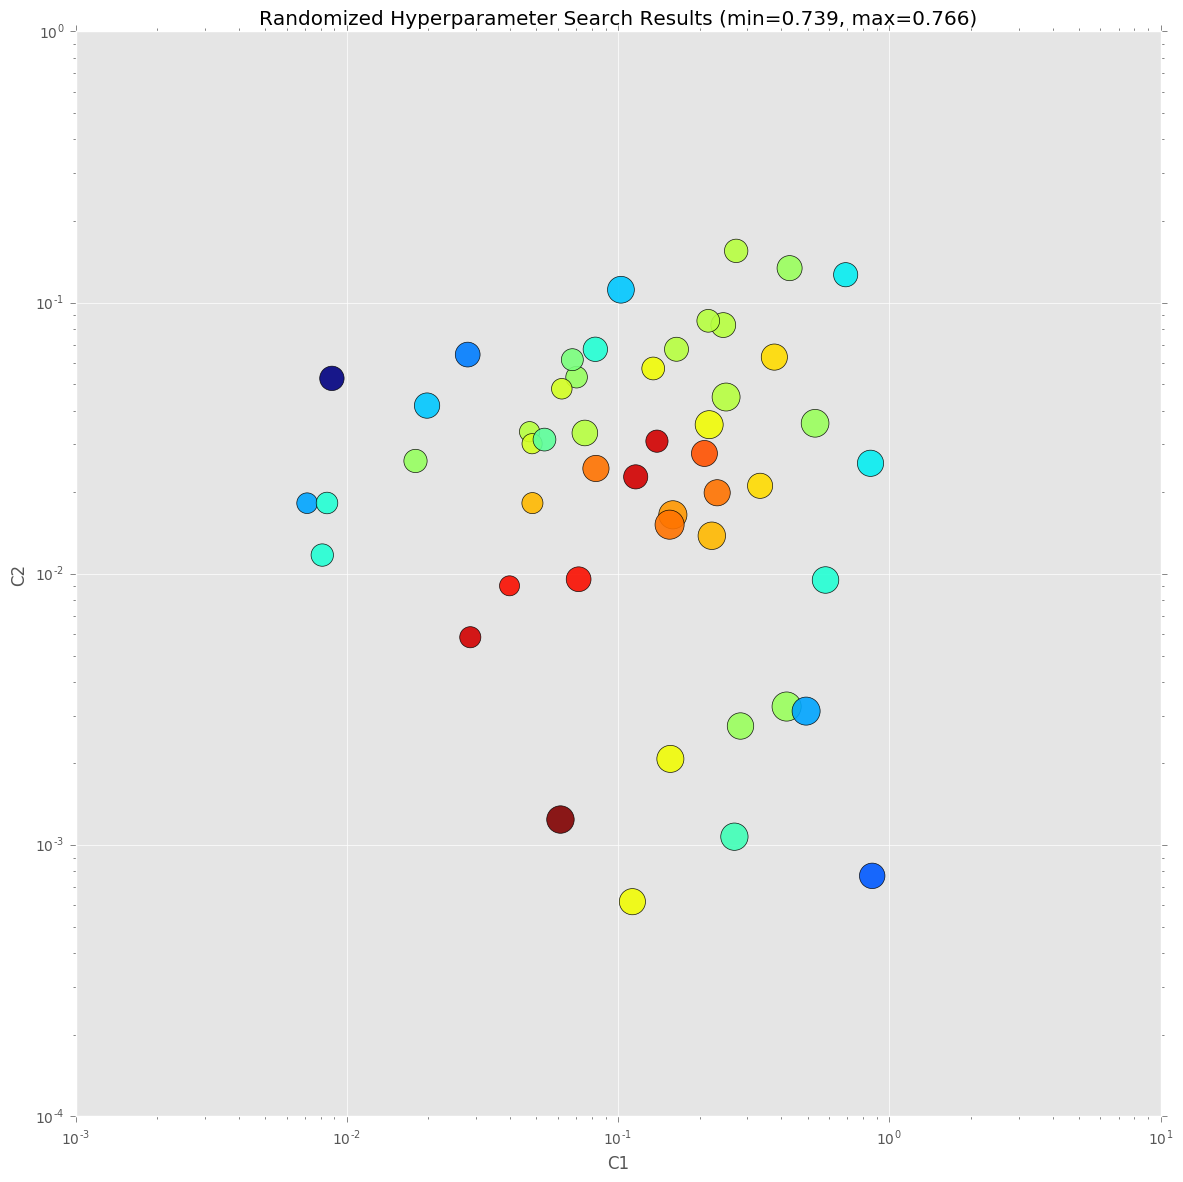

In [15]:
_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = rs.cv_results_['mean_test_score']
_s = [200000*s**2 for s in rs.cv_results_['std_test_score']]

fig = plt.figure()
fig.set_size_inches(14, 14)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=_s, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.3}, dark red => {:0.3}".format(min(_c), max(_c)))

In [16]:
# %%time
crf = rs.best_estimator_
# crf = CRF(c1=0.358, c2=0.161, verbose=False, max_iterations=200)
# crf = CRF(c1=0.217, c2=0.05, verbose=False, max_iterations=30)
# crf = CRF(c1=0.643, c2=0.198, verbose=False, max_iterations=200)
# crf = CRF(c1=0.358, c2=0.161, verbose=False, max_iterations=200)
crf.fit(X_train, y_train)
crf.score(X_test, y_test)

0.87398673544583638

In [17]:
#crf.fit(X, y)

In [18]:
y_pred = crf.predict(X_test)
print(flat_classification_report(
    y_test, y_pred, digits=3, labels=crf.classes_, target_names=crf.classes_
))

                              precision    recall  f1-score   support

                search query      0.900     0.934     0.917       106
                       email      0.952     0.965     0.958       143
                    password      1.000     0.978     0.989        93
            product quantity      1.000     0.583     0.737        12
               submit button      0.968     0.989     0.978        92
                    username      0.839     0.825     0.832        57
       password confirmation      0.880     1.000     0.936        22
 receive emails confirmation      0.857     0.600     0.706        20
                  first name      1.000     0.900     0.947        20
                   last name      0.947     0.900     0.923        20
           organization name      0.600     0.600     0.600         5
                     address      0.933     0.636     0.757        22
                        city      1.000     0.727     0.842        11
                   

/Users/kmike/envs/deepdeep/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [19]:
from eli5 import explain_weights

In [20]:
explain_weights(crf, top=100)

From \ To,search query,email,password,product quantity,submit button,username,password confirmation,receive emails confirmation,first name,last name,organization name,address,city,state,postal code,country,phone,fax,TOS confirmation,comment text,captcha,remember me checkbox,username or email,other,full name,search category / refinement,other read-only,style select,email confirmation,time zone,DST,gender,about me text,reset/clear button,security question,answer to security question,comment title or subject,full date,sorting option,year,url,cancel button,middle name,other number,honeypot,day,month,OpenID
search query,-0.024,0.0,0.0,0.0,1.432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.013,0.0,0.0,0.0,0.0,0.0,-0.435,0.0,0.0,0.0,0.0
email,0.0,-7.491,1.08,0.0,0.698,1.756,-0.208,0.002,0.0,0.0,-0.001,-0.406,0.0,0.0,0.0,0.0,1.661,0.0,-0.006,1.959,0.451,0.0,-0.344,-0.437,0.0,0.0,-0.054,0.0,3.854,0.0,0.0,0.0,0.0,0.0,0.644,0.0,0.76,0.0,0.0,0.0,1.17,0.0,0.0,-0.35,0.0,0.037,0.0,0.0
password,0.0,0.104,-4.749,0.0,0.599,0.0,6.081,-0.09,0.675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.49,0.0,-1.495,-0.933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
product quantity,0.0,0.0,0.0,-0.235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
submit button,0.0,0.0,0.0,0.0,-2.678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.561,0.0,2.332,0.0,0.0,0.0,0.0,0.0,0.0,1.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.49,0.0,0.0,0.0,0.0
username,0.0,2.174,3.884,0.0,-0.183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.262,1.231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
password confirmation,0.0,0.0,0.0,0.0,0.015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005,0.0,0.0,0.0,0.0,-0.993,0.468,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
receive emails confirmation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.323,0.0,0.0,0.0,0.0,0.007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.957,0.0,0.0,0.0
first name,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.443,-1.014,0.0,1.863,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.339,0.0,0.0,0.0,0.0,0.0
last name,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.615,0.0,2.757,1.088,0.0,0.0,2.104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.905,0.0,0.0,0.0,0.0,0.0


In [21]:
# import pandas as pd
# pd.options.display.max_rows = 50
# pd.options.display.max_columns = 50
# labels_short = [field_schema.types[name] for name in labels]

# pd.DataFrame(confusion_matrix(y_true_flat, y_pred_flat, labels), index=labels_short, columns=labels_short)

In [22]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-30s -> %-30s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(100))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-10:])

Top likely transitions:
security question              -> answer to security question    7.988212
month                          -> day                            6.091614
password                       -> password confirmation          6.081344
first name                     -> last name                      4.635425
first name                     -> middle name                    4.339085
sorting option                 -> sorting option                 4.284767
month                          -> year                           4.080661
username                       -> password                       3.883616
email                          -> email confirmation             3.854210
year                           -> month                          3.654063
last name                      -> first name                     3.614979
comment text                   -> honeypot                       3.367398
address                        -> address                        3.302901
day           

In [23]:
def _filtered_state_features(state_features, query, k=1):
    return Counter({
        (attr, label): weight
        for ((attr, label), weight) in state_features.items()
        if (query in attr or query in label) and k*weight >= 0
    })


def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-30s %s" % (weight, label, attr))    
        

def print_top_positive(crf, N, query=''):
    print("\nTop positive:")
    cnt = _filtered_state_features(crf.state_features_, query, 1)
    print_state_features(cnt.most_common(N))
    

def print_top_negative(crf, N, query=''):
    print("\nTop negative:")
    cnt = _filtered_state_features(crf.state_features_, query, -1)
    print_state_features(cnt.most_common()[-N:])
    

def print_top(crf, N, query=''):
    cnt = _filtered_state_features(crf.state_features_, query, 0)
    print_state_features(cnt.most_common(N))
    

print_top(crf, 150, 'form-type')

# print("\nTop negative:")
# print_top_negative(info, 30, 'input-type')

7.737157 search category / refinement   form-type:search
6.673352 search query                   form-type:search
4.459563 remember me checkbox           form-type:login
4.266106 comment title or subject       form-type:contact/comment
3.976500 product quantity               form-type:order/add to cart
3.547590 email                          form-type:join mailing list
3.358119 comment text                   form-type:contact/comment
2.632363 other number                   form-type:search
2.385452 full name                      form-type:contact/comment
2.314582 sorting option                 form-type:search
2.182699 city                           form-type:search
1.919193 receive emails confirmation    form-type:registration
1.862546 username or email              form-type:password/login recovery
1.795732 TOS confirmation               form-type:other
1.726227 style select                   form-type:other
1.673174 other                          form-type:other
1.546691 other numbe